In [4]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

In [5]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [19]:
batch_size = 64

workers = 10

traintransform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize([0.5,], [0.5,])])

testtransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5,], [0.5,])])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=traintransform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=workers)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=testtransform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=workers)


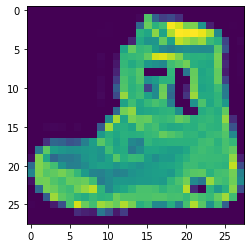

In [20]:
image, label = next(iter(trainloader))

def showImage(img):
    plt.imshow(img.view(28, 28))
showImage(image[1])


In [21]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(3, stride=2, padding=0)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.linear1 = nn.Linear(64*6*6, 512)
        self.linear2 = nn.Linear(512, 10)
        
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        
        x = x.view(-1, 64*6*6)
        x = self.dropout(F.relu(self.linear1(x)))
        x = F.log_softmax(self.linear2(x), dim=1)
        return x

In [22]:
model = Classifier()
model.to(device)
model

Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=2304, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [23]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

image, label = next(iter(trainloader))
image = image.to(device)
label = label.to(device)
image = image.view(image.shape[0], -1)

optimizer.zero_grad()

out = model.forward(image)
criterion(out, label)



tensor(2.3042, device='cuda:0', grad_fn=<NllLossBackward>)

In [24]:
epochs = 5

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

for e in range(epochs):
    running_loss = 0
    test_loss = 0
    test_acc = 0
    model.train()
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        images = images.view(images.shape[0], -1)
        
        optimizer.zero_grad()
        
        out = model.forward(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        model.eval()
        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                out = model.forward(images)
                loss = criterion(out, labels)

                modellabel = torch.argmax(out, dim=1)

                test_loss += loss.item()
                test_acc += float(torch.sum(torch.eq(labels, modellabel))) / float(batch_size)

            print(f"epoch: {e}")
            print(f"test loss: {test_loss/len(testloader)}")
            print(f"test acc: {test_acc/len(testloader)}")
            print(f"training loss: {running_loss/len(trainloader)}")

epoch: 0
test loss: 0.30207884871655966
test acc: 0.887937898089172
training loss: 0.4342870789407286
epoch: 1
test loss: 0.2807357281351545
test acc: 0.8929140127388535
training loss: 0.2747318898119144
epoch: 2
test loss: 0.2848031620500953
test acc: 0.8968949044585988
training loss: 0.23958838437951957
epoch: 3
test loss: 0.2473589887095105
test acc: 0.913515127388535
training loss: 0.22481625245562367
epoch: 4
test loss: 0.2562704445545081
test acc: 0.90734474522293
training loss: 0.20865126355672314
